In [2]:
import pandas as pd
import seaborn
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1st Presidental Debates (Sep)

In [56]:
df = pd.read_csv('labeled_data/us_election_2020_1st_presidential_debate.csv', index_col=0)
df['speaker'] = df['speaker'].str.replace(':','')

df.head(5)

,speaker,minute,text,label,prob,sentiment
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...,10,0.356602,gratitude
1,Chris Wallace,01:20,Good evening from the Health Education Campus ...,3,0.178536,approval
2,Chris Wallace,01:20,Good evening from the Health Education Campus ...,14,0.139196,optimism
3,Chris Wallace,02:10,This debate is being conducted under health an...,3,0.206962,approval
4,Chris Wallace,02:10,This debate is being conducted under health an...,14,0.178687,optimism


In [57]:
def elapsed_to_seconds(elapsed_str):

    template = "%M:%S"
    if elapsed_str is None:
        return None
        
    if elapsed_str.count(':') == 2:
        template = "%H:%M:%S"

    tt = time.strptime(elapsed_str, template)
    
    return tt.tm_hour*60*60 + tt.tm_min*60  + tt.tm_sec

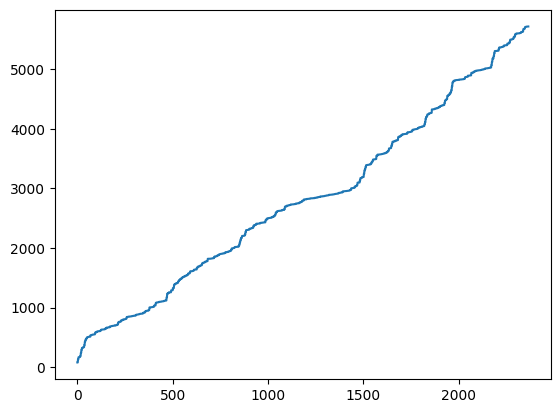

In [58]:
df['minute'] = df['minute'].ffill()
df['seconds_raw'] = df['minute'].apply(elapsed_to_seconds)

df['seconds'] = df['seconds_raw']
df.loc[df.index > 539, 'seconds'] = df.loc[df.index > 539, 'seconds_raw'] + 1465

plt.plot(df.index, df['seconds'])

## Emotion Flow

In [59]:
def get_heatmap_by_speaker(speaker, df):
    return pd.pivot_table(
        df[df['speaker'] == speaker], values='prob', 
        index='seconds', 
        columns='sentiment', 
        fill_value=0, 
        aggfunc='mean'
    ).sort_index().sort_index(axis=1)

pivot = get_heatmap_by_speaker('Vice President Joe Biden', df)

X, Y = np.meshgrid(pivot.index, pivot.columns)
C = pivot.to_numpy()

def plot_sentiment_flow(df, speaker):
    data = get_heatmap_by_speaker(speaker, df)
    
    fig, ax = plt.subplots(figsize=(14,4))
    im = ax.imshow(data.T, aspect='auto', cmap='BuPu')
    
    ax.set_xticks(range(len(data.index)), labels=data.index,
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(data.columns)), labels=data.columns)
    
    ax.set_title(f"Sentiment probability: {speaker}")
    ax.set_xlabel("Second")
    plt.locator_params(axis='x', nbins=50)
    
    plt.show()

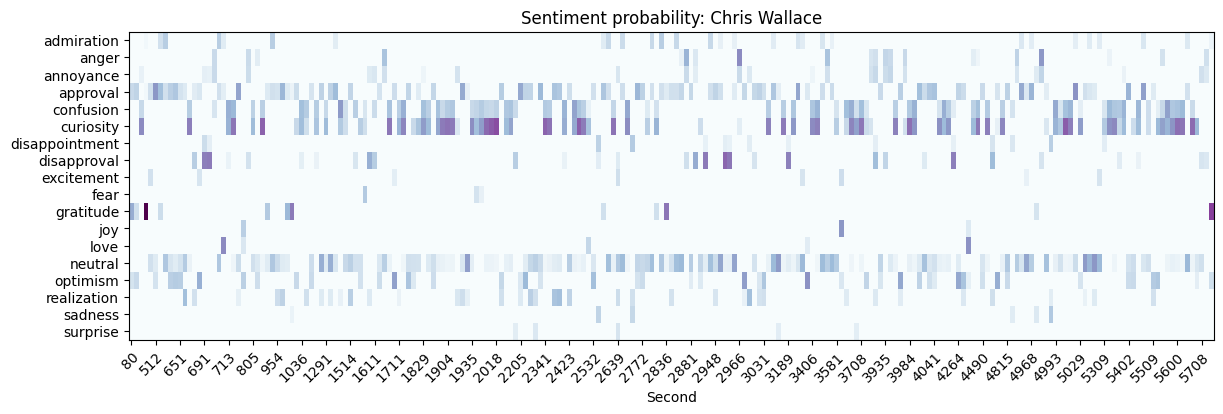

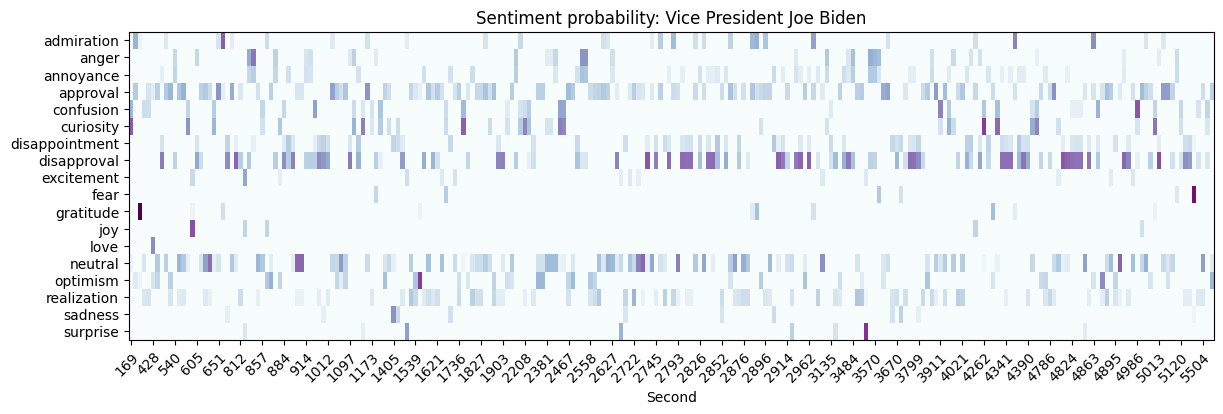

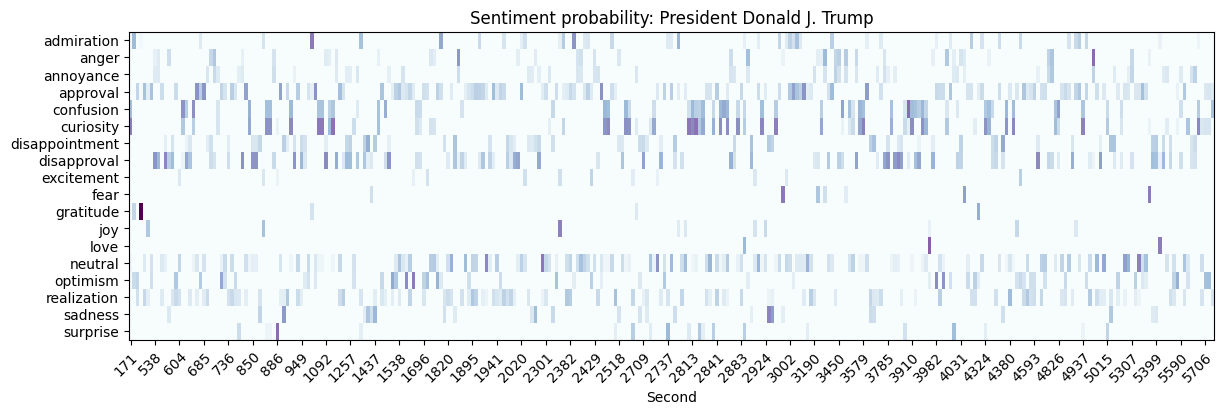

In [60]:
for speaker in df['speaker'].unique():
    plot_sentiment_flow(df, speaker)

## Emotion Profile

In [8]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [9]:
def transform_for_radar_chart(df):
    
    scaler = MinMaxScaler()
    
    
    data = df[df.prob > 0].groupby(['speaker', 'sentiment']).count()['label'].reset_index().rename(columns={'label':'count'})

    data[['count']] = pd.DataFrame(scaler.fit_transform(data[['count']].fillna(0)))
    data = data.pivot(columns='sentiment', index = 'speaker', values='count')
    data = (data.T/data.sum(axis=1)).T
    
    return data

data_sep = transform_for_radar_chart(df)
data_sep

sentiment,admiration,anger,annoyance,approval,confusion,curiosity,disappointment,disapproval,excitement,fear,gratitude,joy,love,neutral,optimism,realization,sadness,surprise
speaker,,,,,,,,,,,,,,,,,,
Chris Wallace,0.042424,0.030303,0.040909,0.139394,0.130303,0.142424,0.021212,0.046970,0.010606,0.003030,0.016667,0.003030,0.006061,0.219697,0.075758,0.057576,0.007576,0.006061
President Donald J. Trump,0.045455,0.044372,0.057359,0.130952,0.071429,0.076840,0.071429,0.101732,0.012987,0.006494,0.004329,0.009740,0.002165,0.145022,0.058442,0.113636,0.027056,0.020563
Vice President Joe Biden,0.039781,0.042524,0.069959,0.148148,0.048011,0.048011,0.093278,0.135802,0.017833,0.006859,0.012346,0.005487,0.000000,0.142661,0.054870,0.109739,0.015089,0.009602


In [10]:
def plot_sentiment_radar(data, labels):
    theta = radar_factory(len(data.columns), frame='polygon')

    spoke_labels = data.columns
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    
    colors = ['b', 'r', 'g']
    
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    
    for d, color in zip(data.to_numpy(), colors):
        ax.plot(theta, d, color=color, alpha=0.3)
        ax.fill(theta, d, facecolor=color, alpha=0.3, label='_nolegend_')
        ax.set_varlabels(spoke_labels)
    
    # add legend relative to top-left plot
    legend = ax.legend(
        labels, loc=(0.9, .95),
        labelspacing=0.1, fontsize='small'
    )
    
    fig.text(
        0.5, 0.965, 'Sentiment Profile',
        horizontalalignment='center', color='black', weight='bold',
        size='large'
    )
    
    plt.show()

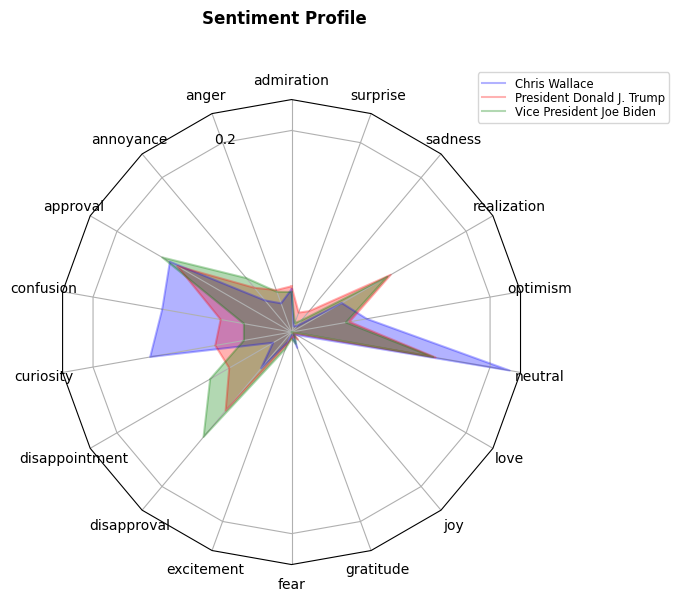

In [11]:
plot_sentiment_radar(data_sep, data_sep.index)

# 2nd Presidental Debates Debates (Oct)

In [12]:
df = pd.read_csv('labeled_data/us_election_2020_2nd_presidential_debate_with_topics.csv', index_col=0)
df.speaker.unique()

array(['Kristen Welker', 'Donald Trump', 'Joe Biden'], dtype=object)

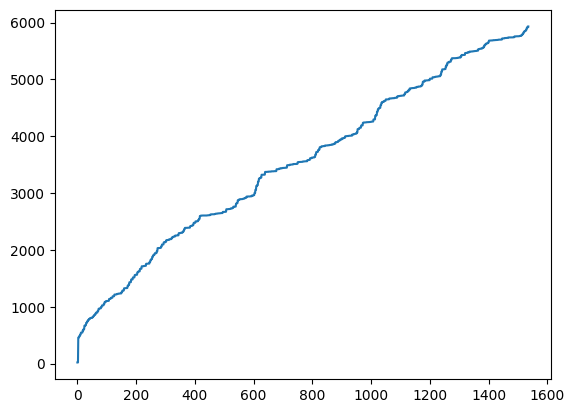

In [13]:
df['minute'] = df['minute'].ffill()
df['seconds_raw'] = df['minute'].apply(elapsed_to_seconds)

df['seconds'] = df['seconds_raw']
df.loc[df.index > 266, 'seconds'] = df.loc[df.index > 266, 'seconds_raw'] + 1942
df.loc[df.index > 1010, 'seconds'] = df.loc[df.index > 1010, 'seconds_raw'] + 4296

plt.plot(df.index, df['seconds'])

## Emotion Flow

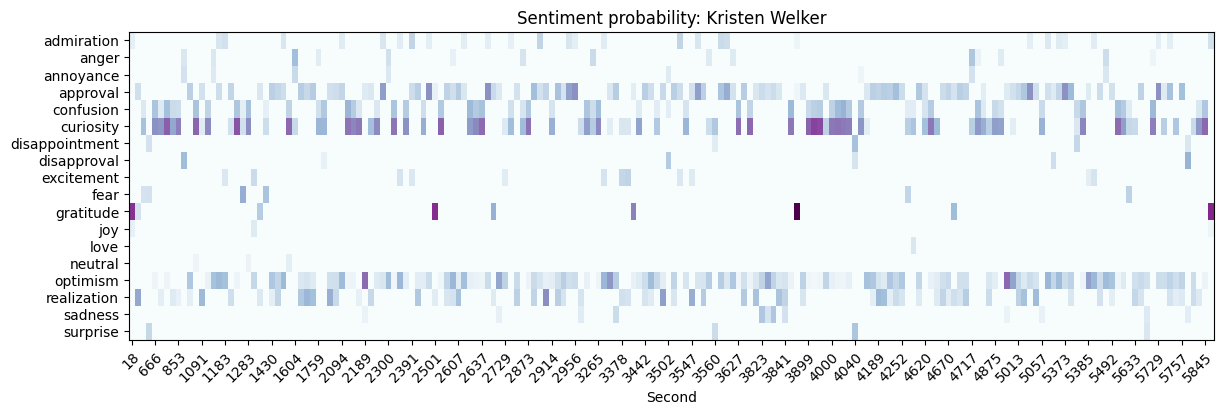

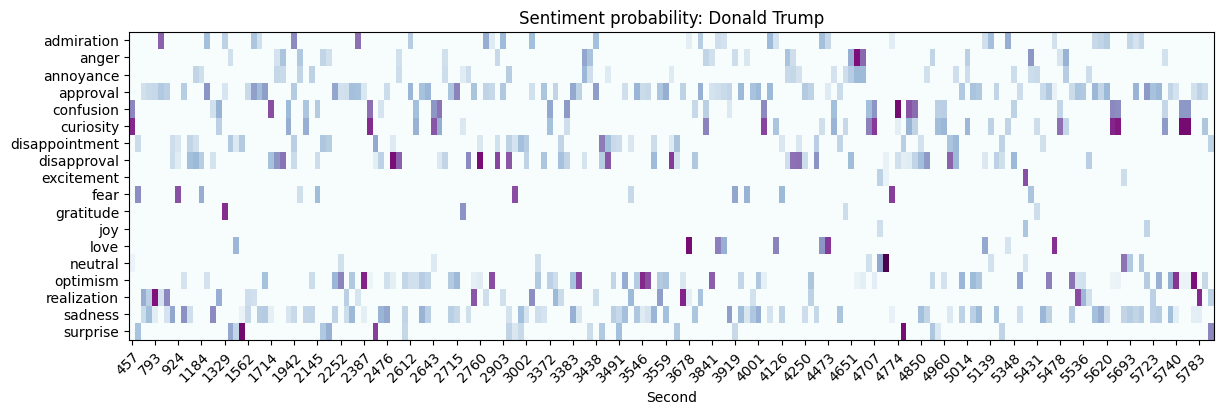

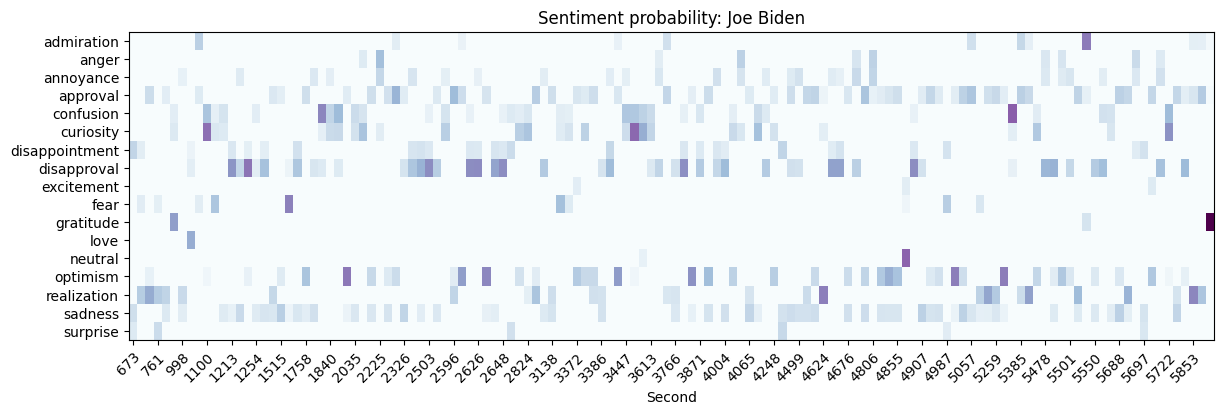

In [52]:
for speaker in df['speaker'].unique():
    plot_sentiment_flow(df, speaker)

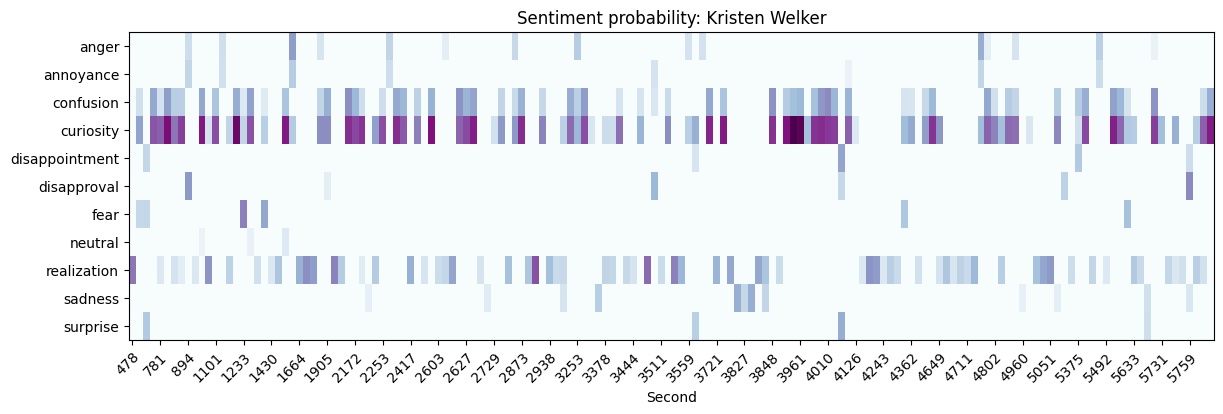

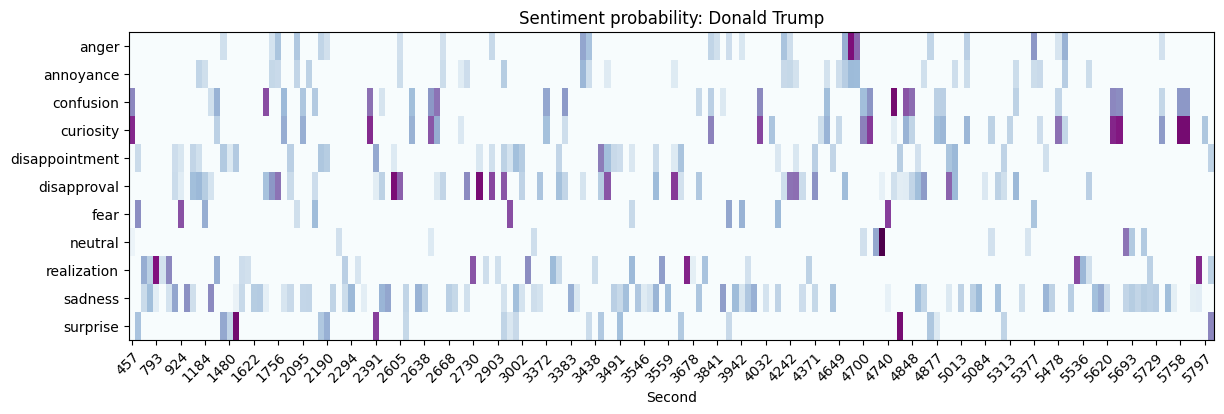

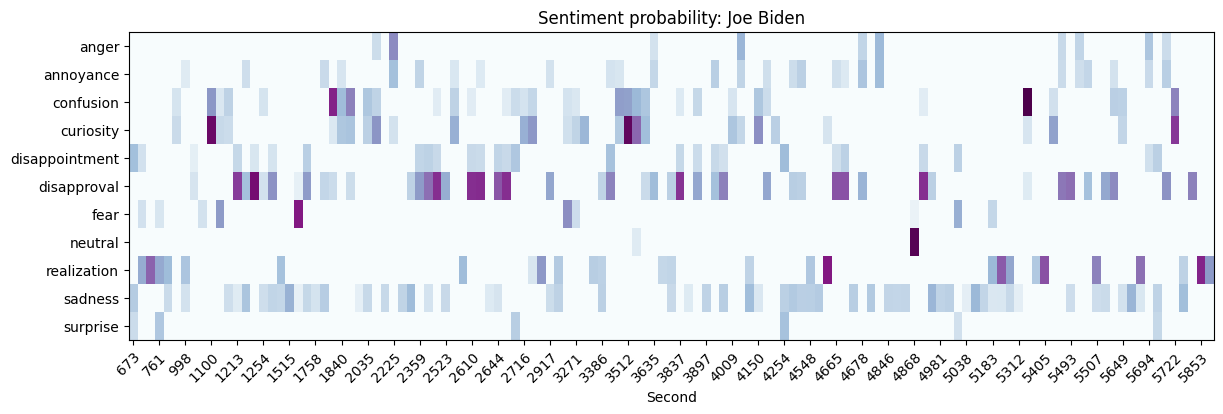

In [53]:
positive_sentiments = ['gratitude', 'joy', 'admiration', 'approval', 'optimism', 'love', 'excitement']

for speaker in df['speaker'].unique():
    plot_sentiment_flow(df[df.sentiment.apply(lambda x: x not in positive_sentiments)], speaker)

In [37]:
df.sentiment.unique()

array(['gratitude', 'joy', 'admiration', 'curiosity', 'confusion',
       'neutral', 'realization', 'approval', 'fear', 'surprise',
       'disappointment', 'sadness', 'optimism', 'disapproval',
       'annoyance', 'anger', 'love', 'excitement'], dtype=object)

In [ ]:
plot_sentiment_flow(df, speaker)

## Emotion Profile

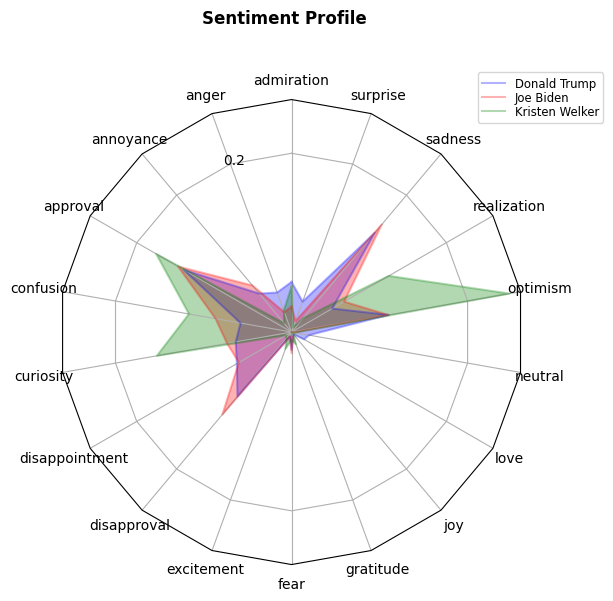

In [17]:
data_oct = transform_for_radar_chart(df)

plot_sentiment_radar(data_oct, data_oct.index)

# Debate Comparison

In [65]:
data_sep['debate'] = '1st debate'
data_oct['debate'] = '2nd debate'

data_merged = pd.concat([data_sep, data_oct])

sentiments = [x for x in data_merged if x != 'debate']

In [64]:
data_merged.filter(like=speaker, axis=0)

sentiment,admiration,anger,annoyance,approval,confusion,curiosity,disappointment,disapproval,excitement,fear,gratitude,joy,love,neutral,optimism,realization,sadness,surprise,debate
speaker,,,,,,,,,,,,,,,,,,,
President Donald J. Trump,0.045455,0.044372,0.057359,0.130952,0.071429,0.076840,0.071429,0.101732,0.012987,0.006494,0.004329,0.009740,0.002165,0.145022,0.058442,0.113636,0.027056,0.020563,sep
Donald Trump,0.056159,0.047101,0.056159,0.139493,0.057971,0.063406,0.070652,0.094203,0.005435,0.019928,0.005435,0.003623,0.016304,0.019928,0.110507,0.052536,0.144928,0.036232,oct


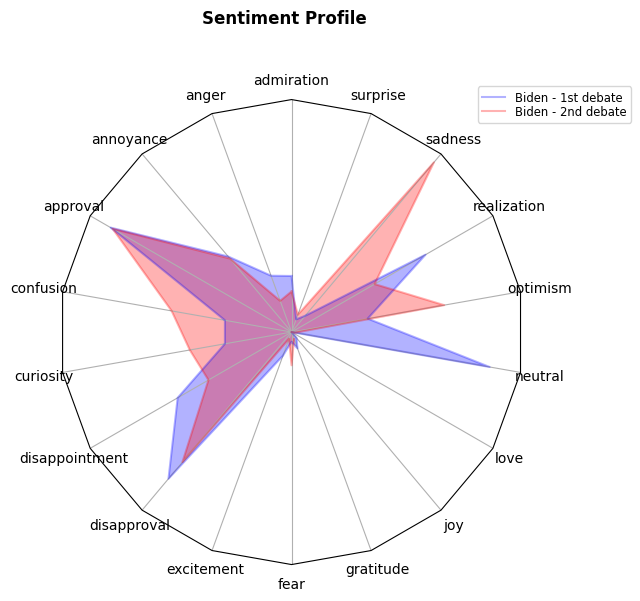

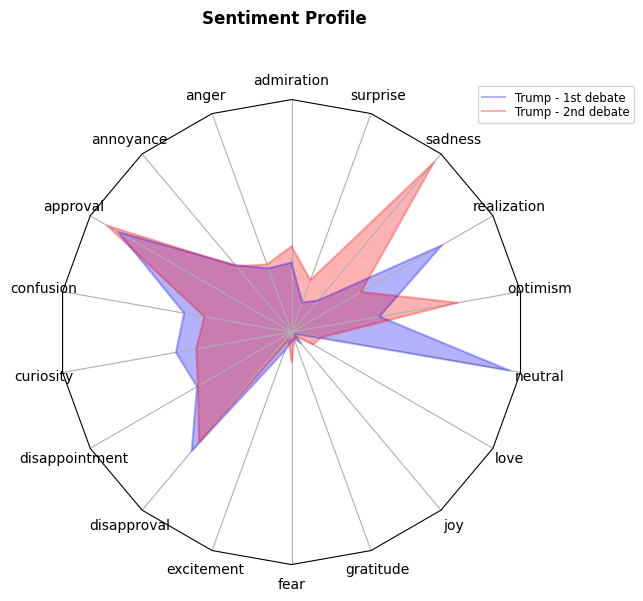

In [68]:
for speaker in ['Biden', 'Trump']:
    labels = [f"{speaker} - {debate}" for debate in data_merged.filter(like=speaker, axis=0)['debate']]
    plot_sentiment_radar(data_merged.filter(like=speaker, axis=0)[sentiments], labels)

# Townhall

## Biden

In [69]:
df = pd.read_csv('labeled_data/us_election_2020_biden_town_hall_labeled.csv', index_col=0)
df.head()

,speaker,minute,text,label,prob,sentiment
0,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",10,0.418097,gratitude
1,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",11,0.161452,joy
2,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",8,0.149983,excitement
3,Joe Biden,00:46,Good to be with you.,0,0.275332,admiration
4,Joe Biden,00:46,Good to be with you.,11,0.187372,joy


In [70]:
df.speaker.unique()

array(['George Stephanopoulos', 'Joe Biden', 'Nicholas Fed', 'Kelly Lee',
       'Anthony Archer', 'Voice Over', 'Cedric Humphrey',
       'George Stephanopoulus', 'Angelia Politarhos', 'Speaker 1',
       'Nathan Osburn', 'Andrew Lewis', 'Speaker 2', 'Michele Ellison',
       'Mark Hoffman', 'Mieke Haeck', 'Speaker 3', 'Keenan Wilson'],
      dtype=object)

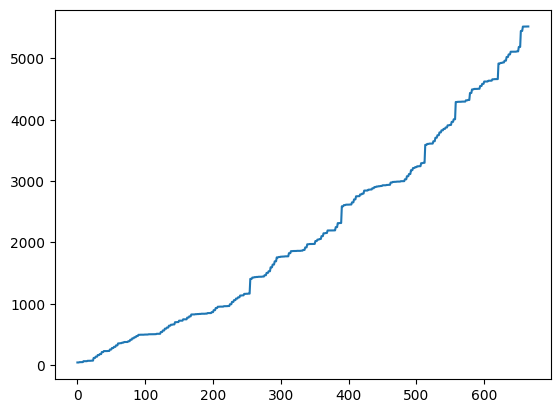

In [71]:
df['minute'] = df['minute'].ffill()
df['seconds'] = df['minute'].apply(elapsed_to_seconds)

plt.plot(df.index, df['seconds'])

In [72]:
df_max_prob = df.loc[df.groupby(['speaker', 'seconds'])['prob'].idxmax()]

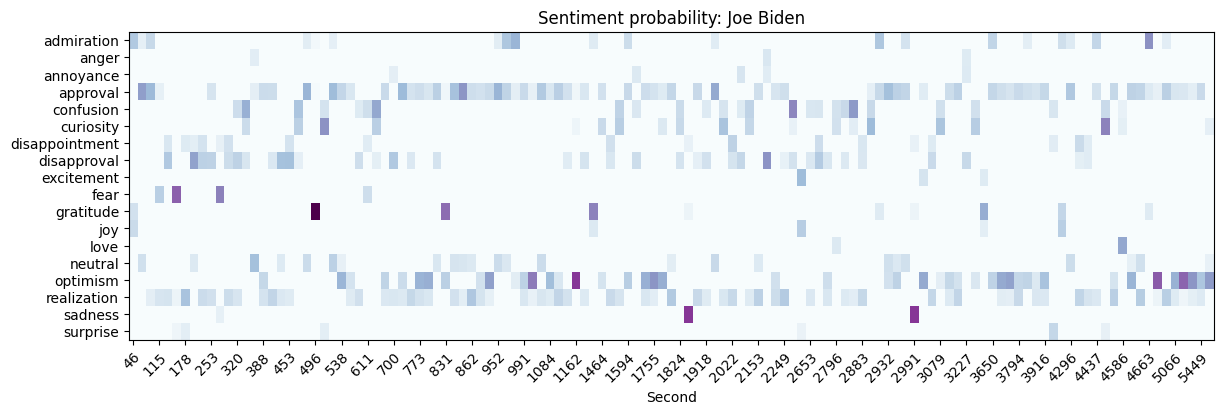

In [73]:
plot_sentiment_flow(df, 'Joe Biden')

In [74]:
sentiments = df.sentiment.unique()
sentiments.sort()

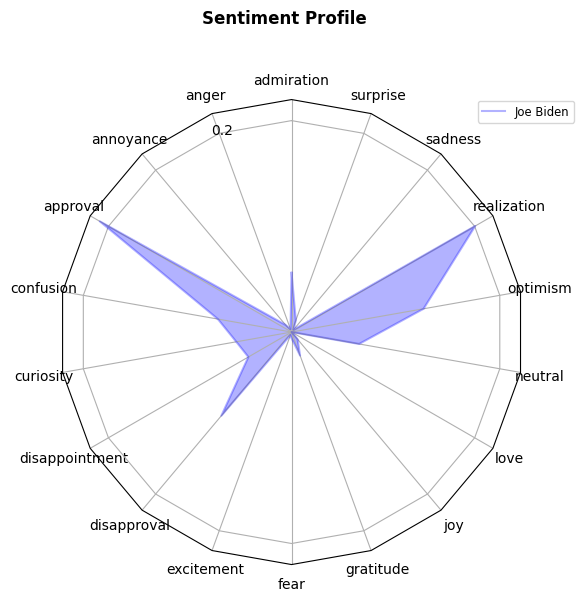

In [75]:
data_b = transform_for_radar_chart(df[df.speaker.str.contains("Biden")])
data_b['event'] = 'Town Hall'

plot_sentiment_radar(data_b[sentiments], ['Joe Biden'])

In [76]:
df = pd.read_csv('labeled_data/us_election_2020_biden_town_hall_labeled.csv', index_col=0)
df.head()

,speaker,minute,text,label,prob,sentiment
0,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",10,0.418097,gratitude
1,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",11,0.161452,joy
2,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid...",8,0.149983,excitement
3,Joe Biden,00:46,Good to be with you.,0,0.275332,admiration
4,Joe Biden,00:46,Good to be with you.,11,0.187372,joy


In [77]:
df.speaker.unique()

array(['George Stephanopoulos', 'Joe Biden', 'Nicholas Fed', 'Kelly Lee',
       'Anthony Archer', 'Voice Over', 'Cedric Humphrey',
       'George Stephanopoulus', 'Angelia Politarhos', 'Speaker 1',
       'Nathan Osburn', 'Andrew Lewis', 'Speaker 2', 'Michele Ellison',
       'Mark Hoffman', 'Mieke Haeck', 'Speaker 3', 'Keenan Wilson'],
      dtype=object)

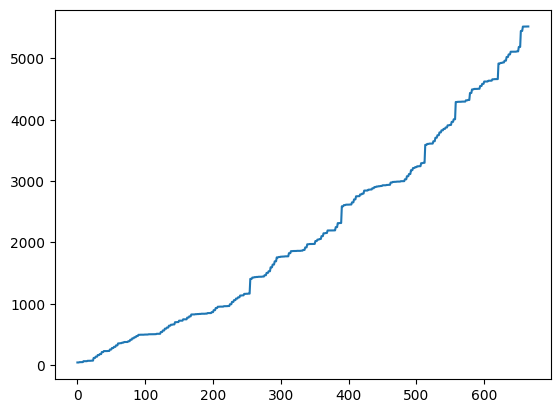

In [78]:
df['minute'] = df['minute'].ffill()
df['seconds'] = df['minute'].apply(elapsed_to_seconds)

plt.plot(df.index, df['seconds'])

In [79]:
df_max_prob = df.loc[df.groupby(['speaker', 'seconds'])['prob'].idxmax()]

In [80]:
df_max_prob.speaker.unique()

array(['Andrew Lewis', 'Angelia Politarhos', 'Anthony Archer',
       'Cedric Humphrey', 'George Stephanopoulos',
       'George Stephanopoulus', 'Joe Biden', 'Keenan Wilson', 'Kelly Lee',
       'Mark Hoffman', 'Michele Ellison', 'Mieke Haeck', 'Nathan Osburn',
       'Nicholas Fed', 'Speaker 1', 'Speaker 2', 'Speaker 3',
       'Voice Over'], dtype=object)

In [87]:
data = transform_for_radar_chart(df_max_prob[df_max_prob.speaker.str.contains("Biden")])
data_merged = pd.concat([data, data_oct.filter(like='Biden', axis=0)[sentiments]])
data_merged

sentiment,admiration,approval,confusion,curiosity,disappointment,disapproval,excitement,fear,gratitude,joy,love,neutral,optimism,realization,sadness,surprise,anger,annoyance
speaker,,,,,,,,,,,,,,,,,,
Joe Biden,0.045872,0.174312,0.064220,0.082569,0.000000,0.146789,0.000000,0.027523,0.027523,0.0,0.0,0.000000,0.284404,0.137615,0.009174,0.000000,NaN,NaN
Joe Biden,0.028796,0.146597,0.086387,0.073298,0.068063,0.120419,0.005236,0.023560,0.005236,NaN,0.0,0.002618,0.109948,0.068063,0.157068,0.013089,0.02356,0.068063


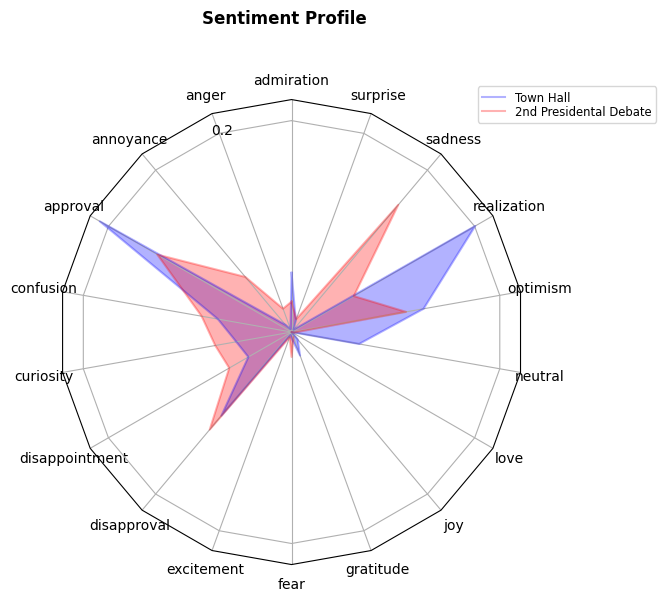

In [88]:
data_oct['event'] = '2nd Presidental Debate'

data_merged = pd.concat([data_b, data_oct])

plot_sentiment_radar(data_merged.filter(like='Biden', axis=0)[sentiments], data_merged.event)

## Trump

In [89]:
df = pd.read_csv('labeled_data/us_election_2020_trump_town_hall_labeled.csv', index_col=0)
df.head()

,speaker,minute,text,label,prob,sentiment
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",8,0.220407,excitement
1,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",0,0.146016,admiration
2,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",11,0.124338,joy
3,Speaker 1,04:35,This is an NBC news special presentation of To...,8,0.219072,excitement
4,Speaker 1,04:35,This is an NBC news special presentation of To...,13,0.152846,neutral


In [90]:
df.groupby('sentiment').count()

,speaker,minute,text,label,prob
sentiment,,,,,
admiration,101,101,101,101,101
anger,23,23,23,23,23
annoyance,29,29,29,29,29
approval,185,185,185,185,185
confusion,125,125,125,125,125
curiosity,120,120,120,120,120
disappointment,47,47,47,47,47
disapproval,85,85,85,85,85
excitement,15,15,15,15,15


In [91]:
df.speaker.unique()

array(['Savannah Guthrie', 'Speaker 1', 'President Trump',
       'Jacqueline Lugo', 'Barbara Peña', 'Isabella Peña', 'Savannah',
       'Cristy Montesinos Alonso', 'Adam Schucher', 'Moriah Geene',
       'Cindy Velez', 'Paulette Dale'], dtype=object)

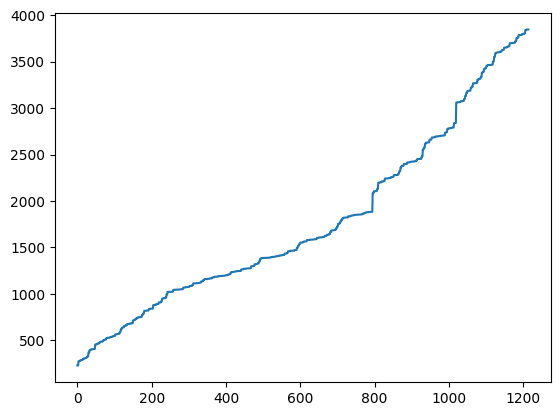

In [92]:
df['minute'] = df['minute'].ffill()
df['seconds'] = df['minute'].apply(elapsed_to_seconds)

plt.plot(df.index, df['seconds'])

In [93]:
df_max_prob = df.loc[df.groupby(['speaker', 'seconds'])['prob'].idxmax()]

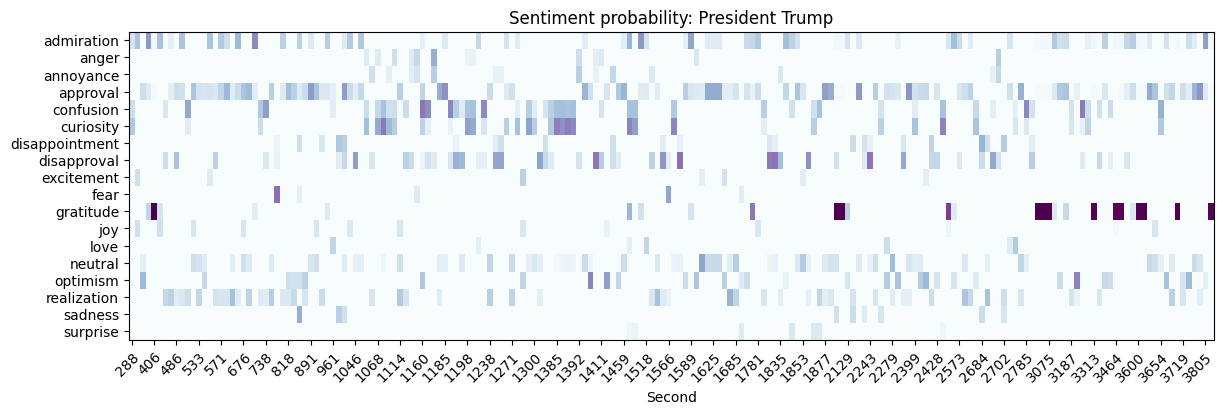

In [94]:
plot_sentiment_flow(df, 'President Trump')

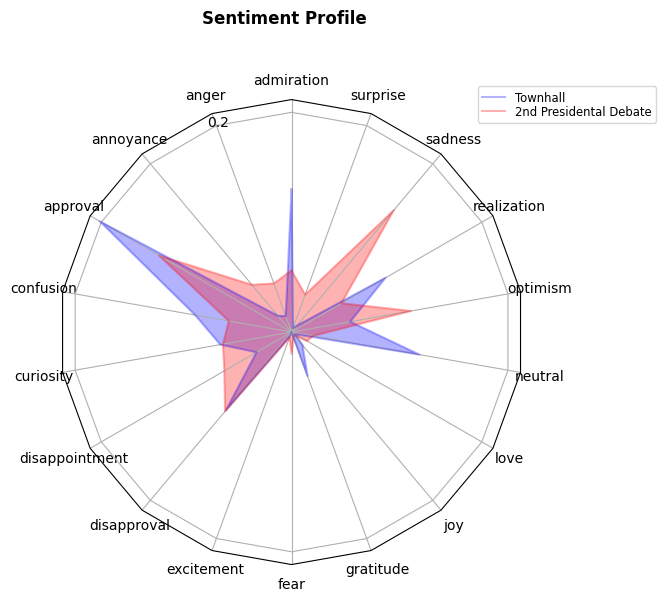

In [96]:
data_t['event'] = 'Townhall'

data_merged = pd.concat([data_t, data_oct])

plot_sentiment_radar(data_merged.filter(like='Trump', axis=0)[sentiments], data_merged.event)

## Trump vs Biden

In [97]:
data_merged

sentiment,admiration,anger,annoyance,approval,confusion,curiosity,disappointment,disapproval,excitement,fear,gratitude,joy,love,neutral,optimism,realization,sadness,surprise,event,debate
speaker,,,,,,,,,,,,,,,,,,,,
President Trump,0.129845,0.015504,0.019380,0.201550,0.089147,0.065891,0.036822,0.093023,0.003876,0.000000,0.042636,0.015504,0.003876,0.118217,0.054264,0.098837,0.007752,0.003876,Townhall,NaN
Donald Trump,0.056159,0.047101,0.056159,0.139493,0.057971,0.063406,0.070652,0.094203,0.005435,0.019928,0.005435,0.003623,0.016304,0.019928,0.110507,0.052536,0.144928,0.036232,2nd Presidental Debate,2nd debate
Joe Biden,0.028796,0.023560,0.068063,0.146597,0.086387,0.073298,0.068063,0.120419,0.005236,0.023560,0.005236,NaN,0.000000,0.002618,0.109948,0.068063,0.157068,0.013089,2nd Presidental Debate,2nd debate
Kristen Welker,0.051002,0.025501,0.012750,0.174863,0.116576,0.153005,0.007286,0.009107,0.020036,0.009107,0.014572,0.003643,0.000000,0.003643,0.247723,0.125683,0.020036,0.005464,2nd Presidental Debate,2nd debate


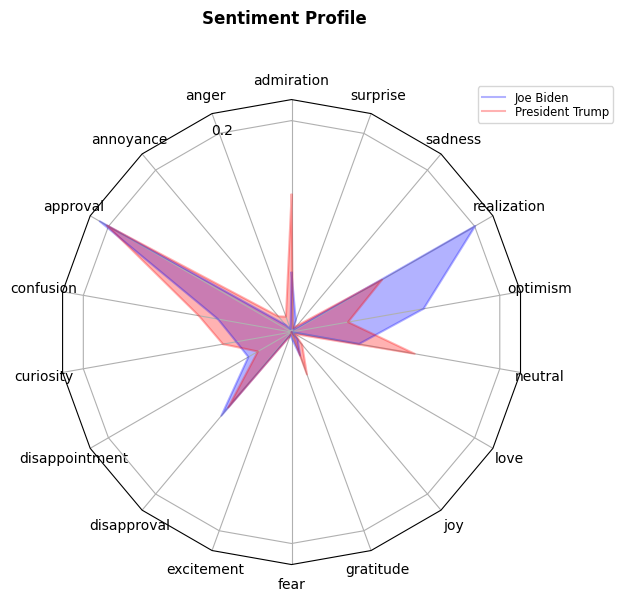

In [98]:
data_merged = pd.concat([data_b, data_t])
speakers = ['Biden', 'Trump']

plot_sentiment_radar(data_merged[sentiments], data_merged.index)

# Topic analysis

In [101]:
df = pd.read_csv('labeled_data/us_election_2020_2nd_presidential_debate_with_topics.csv')
df.head()

,Unnamed: 0,speaker,minute,text,topic,label,prob,sentiment
0,0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo...",1_biden_vicepresident_vice_president,10,0.650881,gratitude
1,1,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo...",1_biden_vicepresident_vice_president,11,0.075309,joy
2,2,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo...",1_biden_vicepresident_vice_president,0,0.072984,admiration
3,3,Donald Trump,07:37,How are you doing? How are you?,-1_immigration_trump_cages_president,5,0.488374,curiosity
4,4,Donald Trump,07:37,How are you doing? How are you?,-1_immigration_trump_cages_president,4,0.326039,confusion


In [102]:
df.groupby(['speaker', 'topic', 'sentiment'])[['sentiment']].count()

sentiment
speaker        topic                                sentiment             
Donald Trump   -1_immigration_trump_cages_president admiration           5
                                                    anger                9
                                                    annoyance           13
                                                    approval            13
                                                    confusion            7
...                                                                    ...
Kristen Welker 9_families_family_parents_reunite    disapproval          1
                                                    love                 1
                                                    optimism             5
                                                    realization          2
                                                    surprise             1

[383 rows x 1 columns]

In [103]:
df['topic'].unique()

array(['1_biden_vicepresident_vice_president',
       '-1_immigration_trump_cages_president',
       '0_obamacare_healthcare_vaccine_insurance',
       '3_emissions_environmental_fracking_climate',
       '8_trump_president_bernie_nobody', '2_china_putin_chinas_russia',
       '9_families_family_parents_reunite',
       '11_respond_response_have_that',
       '12_seconds_president_trump_quickly', '4_did_didnt_said_had',
       '6_okay_lets_followup_let', '10_crosstalk_001104_001130_wall',
       '7_okay___', '13_korea_korean_missiles_missile',
       '5_prison_justice_reform_jail'], dtype=object)

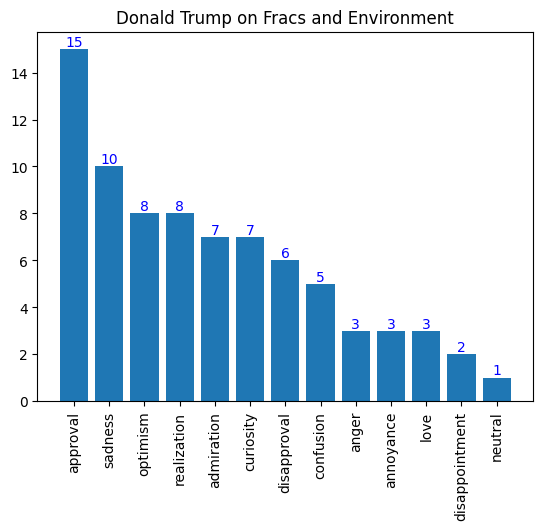

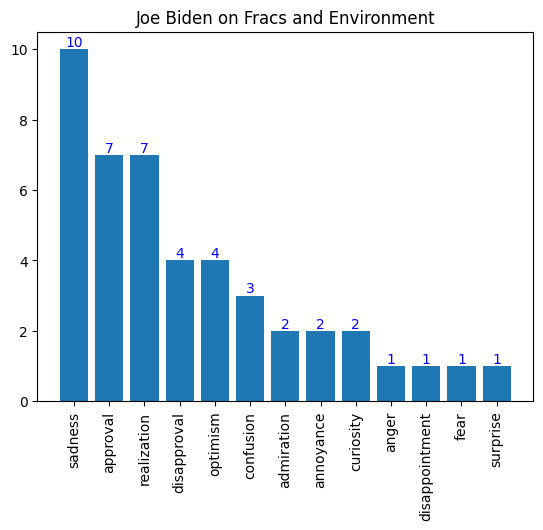

In [132]:
speakers = ['Donald Trump', 'Joe Biden']
topic = "3_emissions_environmental_fracking_climate"

topic_to_title = {
    "0_obamacare_healthcare_vaccine_insurance": "Health, vaccines and Obamacare",
    "3_emissions_environmental_fracking_climate": "Fracs and Environment"
}


for speaker in speakers:
    grouped = df[(df.speaker == speaker) & (df.topic == topic)]\
        .groupby(['speaker', 'topic', 'sentiment'])[['sentiment']].count()
    grouped.columns = ['count']
    grouped = grouped.reset_index().sort_values(by="count", ascending=False)
    fig, ax = plt.subplots()
    bars = ax.bar(grouped["sentiment"], grouped["count"])
    
    ax.bar_label(bars, label_type='edge', color='blue')
    plt.xticks(rotation=90)
    topic_title = topic_to_title[topic]
    plt.title(f"{speaker} on {topic_title}")
    plt.show()